# Explore dataset

## Set-up

### Imports

In [1]:
# imports - general
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import welch

# imports - custom
import sys
sys.path.append("../code")
from info import FS, N_CHANNELS#, N_SPECIES

# autoreload
%load_ext autoreload
%autoreload 2

## Main

### Load data

In [2]:
# load example file
i_file = 0

# import
path = '../../../datasets/adamatzky_2021/txt'
files = os.listdir(path)
print(f"Importing: {files[i_file]}")
data = pd.read_csv(os.path.join(path, files[i_file]), sep='\t')

# check signal duration
n_samples = len(data)
print(f"\nNumber of samples: {n_samples}")
print(f"Signal duration: \n\t{n_samples/FS} seconds \n\t~{n_samples/(FS*60):.0f} minutes \n\t~{n_samples/(FS*60*60):.0f} hours \n\t~{n_samples/(FS*60*60*24):.0f} days")

# show
data

Importing: cordyceps_militari.txt

Number of samples: 1900145
Signal duration: 
	1900145.0 seconds 
	~31669 minutes 
	~528 hours 
	~22 days


,Differential 1 - 2 Ave. (mV),Differential 3 - 4 Ave. (mV),Differential 5 - 6 Ave. (mV),Differential 7 - 8 Ave. (mV),Differential 9 - 10 Ave. (mV),Differential 11 - 12 Ave. (mV),Differential 13 - 14 Ave. (mV),Unnamed: 7,Unnamed: 8,Unnamed: 9
0,-0.448,-1.762,1.349,3.886,0.241,-0.881,0.502,0.000000,0.0,0.0
1,-0.450,-1.727,1.455,3.838,0.228,-0.881,0.461,0.000000,0.0,0.0
2,-0.404,-1.620,1.709,3.779,0.233,-0.892,0.340,0.062631,0.0,0.0
3,-0.305,-1.528,1.923,3.797,0.272,-0.901,0.245,0.107730,0.0,0.0
4,-0.194,-1.502,1.906,3.874,0.318,-0.911,0.237,0.126773,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
1900140,0.792,-0.355,0.913,-0.335,1.581,0.249,0.756,NaN,NaN,NaN
1900141,0.791,-0.276,1.028,-0.326,1.591,0.234,0.679,NaN,NaN,NaN
1900142,0.791,-0.208,0.834,-0.309,1.585,0.229,0.673,NaN,NaN,NaN
1900143,0.792,-0.151,0.848,-0.271,1.590,0.216,0.708,NaN,NaN,NaN


Something isn't matching up here. The documentation states that the sampling frequency is 1 Hz and the recording length is 1.5 days for S. commune and c. 5 days for the other species. Yet, here, the signal durations works out to be much longer (3 days for S. commune and 12+, 20+, and 35+ days for the others)

In [3]:
# check for NaN
print(f"Number of NaNs: \n{np.sum(np.isnan(data))}")

Number of NaNs: 
Differential 1 - 2 Ave. (mV)          90
Differential 3 - 4 Ave. (mV)          90
Differential 5 - 6 Ave. (mV)          90
Differential 7 - 8 Ave. (mV)          90
Differential 9 - 10 Ave. (mV)         90
Differential 11 - 12 Ave. (mV)        90
Differential 13 - 14 Ave. (mV)        90
Unnamed: 7                        852575
Unnamed: 8                        851569
Unnamed: 9                        851569
dtype: int64


### Plot time-series

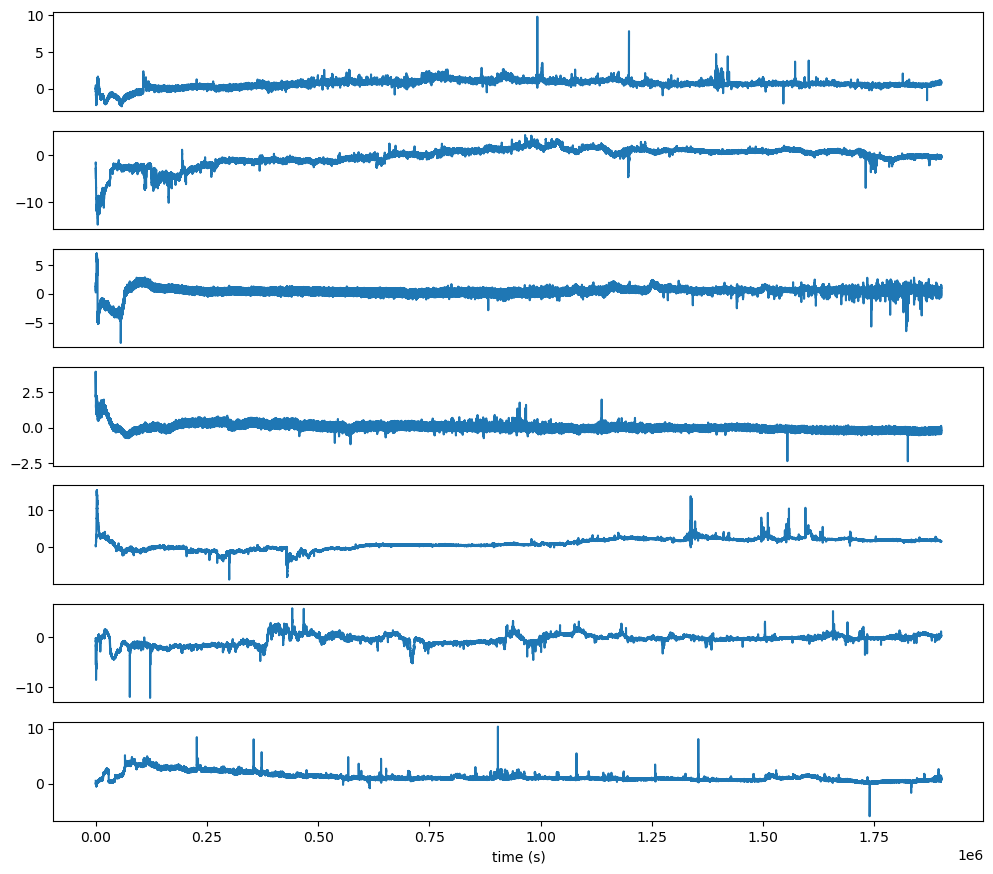

In [4]:
# plot each channel
time = np.arange(n_samples) / FS

fig, ax = plt.subplots(N_CHANNELS, 1, figsize=(12, N_CHANNELS*1.5))
for i in range(N_CHANNELS):
    ax[i].plot(time, data.iloc[:, i])
    if i < N_CHANNELS-1:
        ax[i].set(xticks=[], xlabel='')

ax[N_CHANNELS-1].set(xlabel='time (s)');

All channels exhibit large deflections at the beginning of the recording, which may be due to the experimental manipulation.

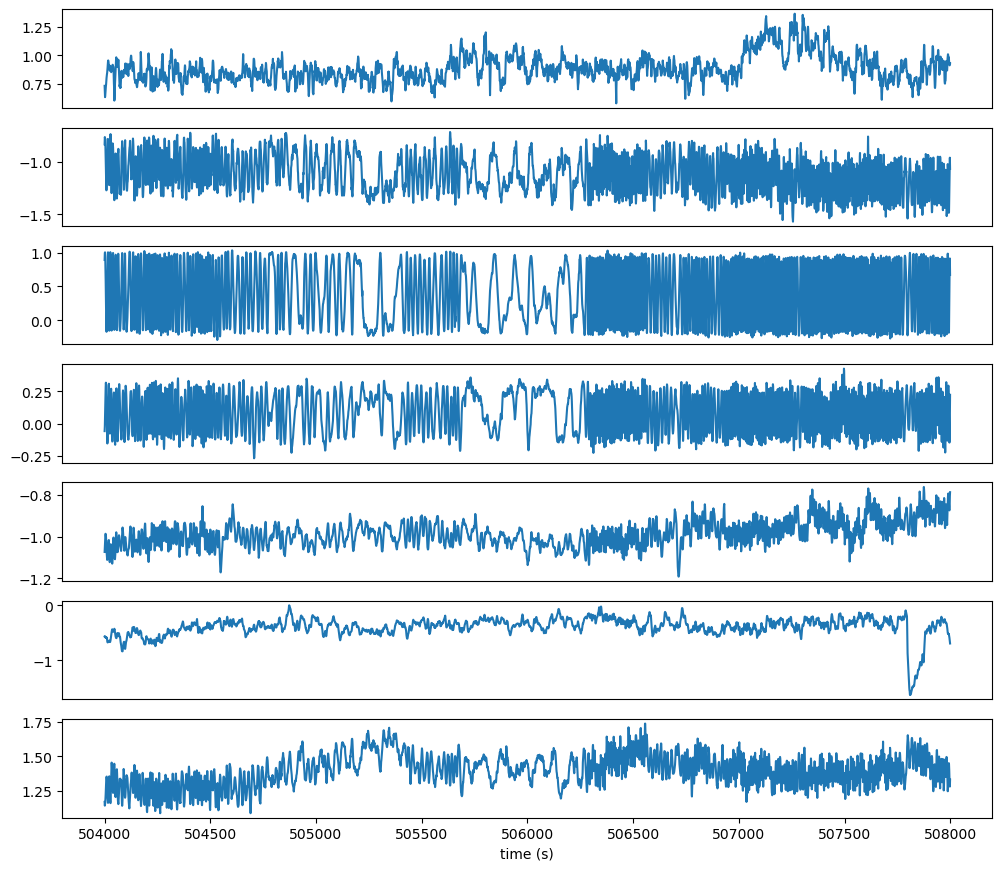

In [5]:
# plot a snippet of each channel
fig, ax = plt.subplots(N_CHANNELS, 1, figsize=(12, N_CHANNELS*1.5))
for i in range(N_CHANNELS):
    ax[i].plot(time[504000:508000], data.iloc[504000:508000, i])
    if i < N_CHANNELS-1:
        ax[i].set(xticks=[], xlabel='')

ax[N_CHANNELS-1].set(xlabel='time (s)');

For file 0, channels 1, 2, and 3 appear to transition between bouts of slow wave activity and white-noise-like activity.

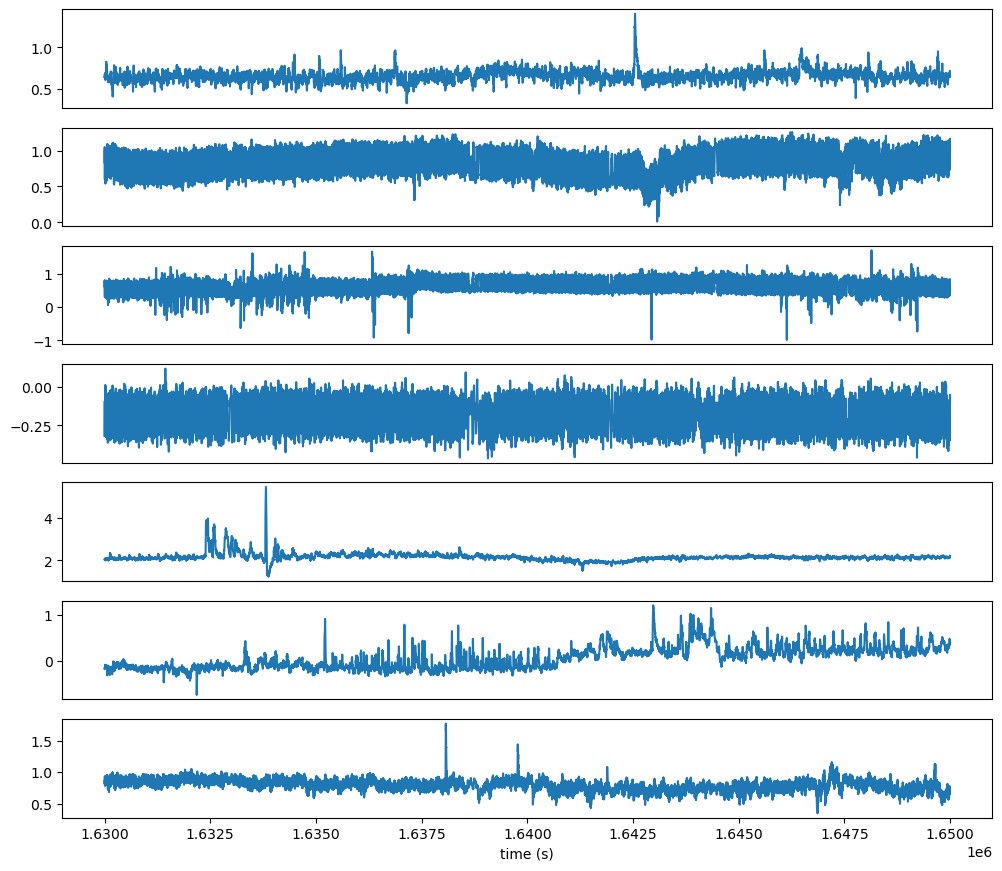

In [15]:
# plot another snippet of each channel
fig, ax = plt.subplots(N_CHANNELS, 1, figsize=(12, N_CHANNELS*1.5))
for i in range(N_CHANNELS):
    ax[i].plot(time[1630000:1650000], data.iloc[1630000:1650000, i])
    if i < N_CHANNELS-1:
        ax[i].set(xticks=[], xlabel='')

ax[N_CHANNELS-1].set(xlabel='time (s)');

Recordings also exhibit large voltage defections (spikes) with both positive and negative amplitude. 

### Plot power spectra

In [7]:
# interpolate NaN values in signal (for computing spectra)
data = data.interpolate(method='linear', axis=0)

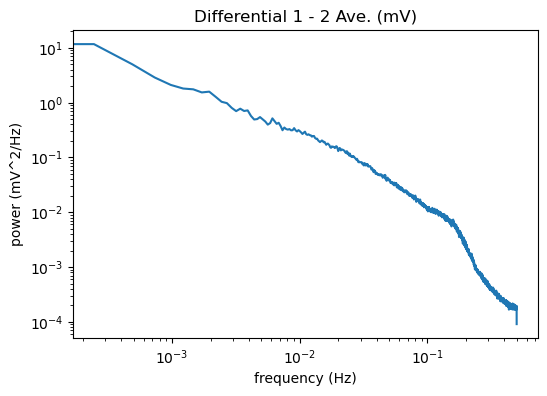

In [22]:
# plot power spectrum for example channel
i_col = 0

# compute power
signal = data.iloc[:, i_col].values
freq, power = welch(signal, fs=FS, nperseg=2**12)

# plot
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.loglog(freq, power)
ax.set(xlabel='frequency (Hz)', ylabel='power (mV^2/Hz)', title=data.columns[i_col])
plt.show()


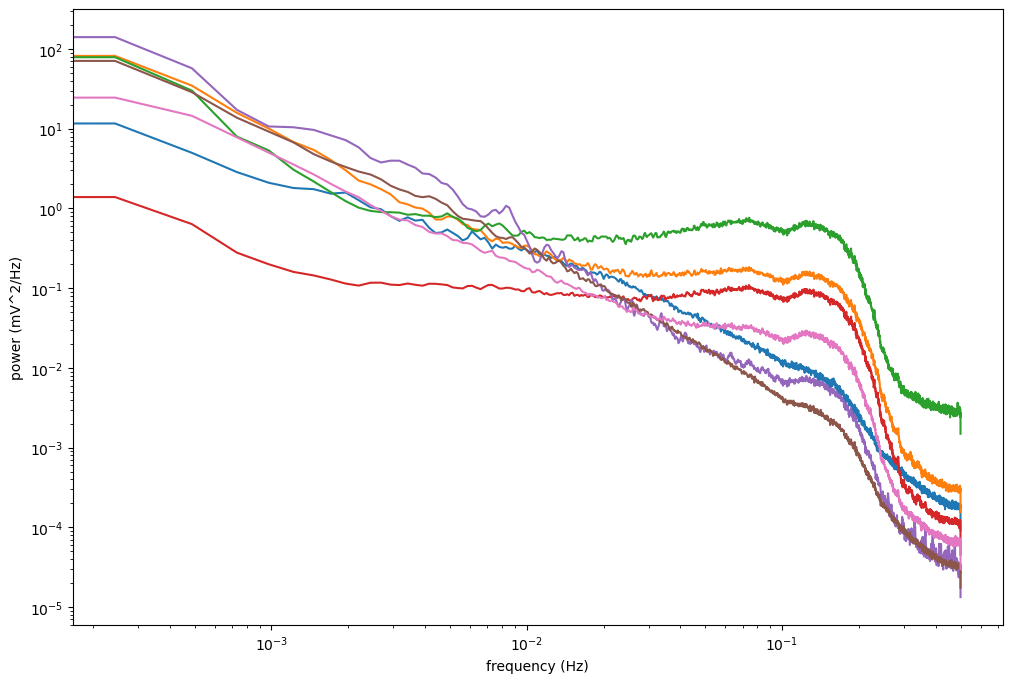

In [9]:
# compute spectra for each channel
spectra = np.zeros((N_CHANNELS, len(freq)))
for i in range(N_CHANNELS):
    freq, power = welch(data.iloc[:, i].values, fs=FS, nperseg=2**12)
    spectra[i, :] = power

# plot
fig, ax = plt.subplots(figsize=(12, 8))
ax.loglog(freq, spectra.T)
ax.set(ylabel='power (mV^2/Hz)', xlabel='frequency (Hz)')
plt.show()

Spectra exhibit a 1/f-like form i.e. decreasing power with increasing frequency, that is roughly linear in log-log space. Additionally, a broad peak is apparent in the spectra, which may reflect the aforementioned slow-wave-like bouts or action-potential-like spikes. 